Прочитайте базу my_PJME_MW.csv и сделайте ее перрасчет (ресемплинг) в представление по 1 месяцу.

Подберите параметры модели SARIMAX для этого ряда.



In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np 
import pandas as pd 
import seaborn as sns

from sklearn.metrics import mean_squared_error

import os

In [2]:
import scipy.stats as scs

In [3]:
import statsmodels.api as sm

C:\Users\Sladkish\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:49: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


In [4]:
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt

In [5]:
Path_Energy ='my_PJME_MW.csv'

In [6]:
data = pd.read_csv(Path_Energy, index_col=[0], parse_dates=[0])
data.head()

,Time,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,,
2002-01-01,01:00:00,30393.0,2002,1,1,1,1,1,1,1,1,0,0
2002-01-01,02:00:00,29265.0,2002,1,1,1,1,1,1,2,1,0,0
2002-01-01,03:00:00,28357.0,2002,1,1,1,1,1,1,3,1,0,0
2002-01-01,04:00:00,27899.0,2002,1,1,1,1,1,1,4,1,0,0
2002-01-01,05:00:00,28057.0,2002,1,1,1,1,1,1,5,1,0,0


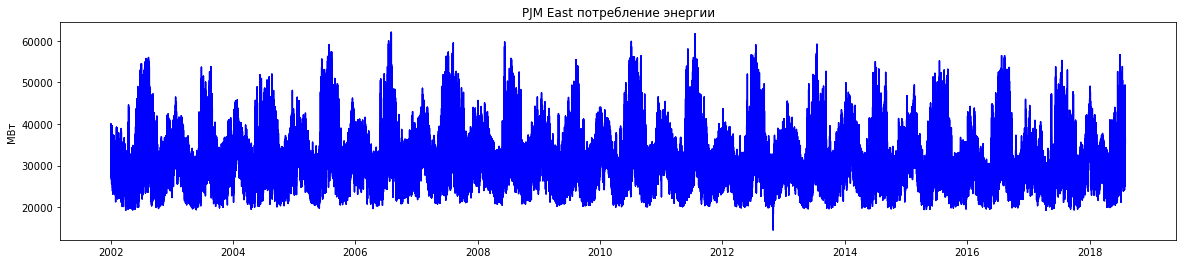

In [7]:
plt.figure(figsize =(20,4))
plt.plot( data.index, data['PJME_MW'], 'b' )
plt.title('PJM East потребление энергии' )
plt.ylabel ( 'МВт' )
plt.show()

In [8]:
data_m = data.resample('M').mean()

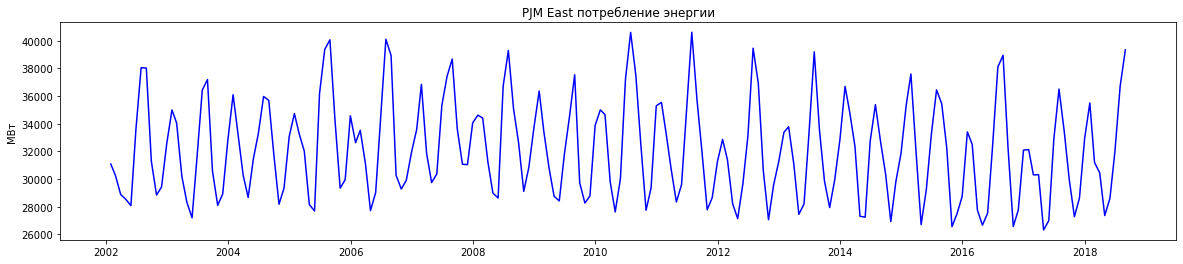

In [9]:
plt.figure(figsize =(20,4))
plt.plot( data_m.index, data_m['PJME_MW'], 'b' )
plt.title('PJM East потребление энергии' )
plt.ylabel ( 'МВт' )
plt.show()

In [10]:
data_d = data.copy().resample('D').mean()
data_w = data.resample('W').mean()
data_Y = data.resample('3M').mean()

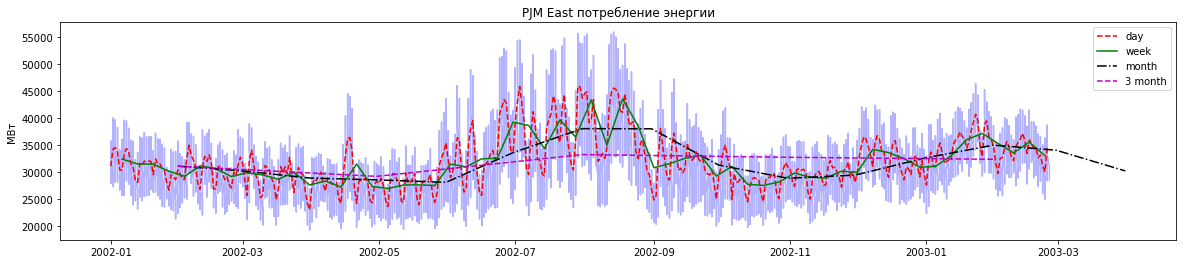

In [11]:
plt.figure(figsize =(20,4))
plt.plot( data.index[:5*24*7*4*3], data['PJME_MW'].values[:5*24*7*4*3], 'b',alpha =0.3 )
plt.plot( data_d.index[:5*7*4*3], data_d['PJME_MW'].values[:5*7*4*3], '--r',label='day' )
plt.plot( data_w.index[:5*4*3], data_w['PJME_MW'].values[:5*4*3], 'g',label='week'  )
plt.plot( data_m.index[:5*3], data_m['PJME_MW'].values[:5*3], '-.k',label='month'  )
plt.plot( data_Y.index[:5], data_Y['PJME_MW'].values[:5], '--m',label='3 month'  )
plt.title('PJM East потребление энергии' )
plt.ylabel ( 'МВт' )
plt.legend()
plt.show()

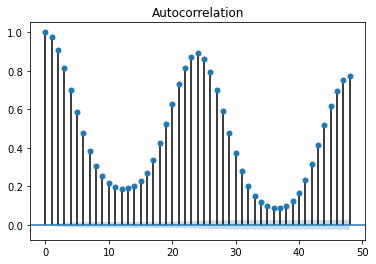

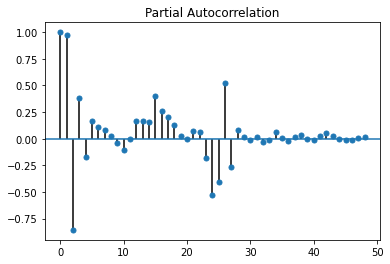

In [12]:
sm.graphics.tsa.plot_acf(data['PJME_MW'].values, lags=24*2)
plt.show()
sm.graphics.tsa.plot_pacf(data['PJME_MW'].values, lags=24*2)
plt.show()

Здесь я решил, что нужно брать период 12 недель. Насколько это верно я не знаю

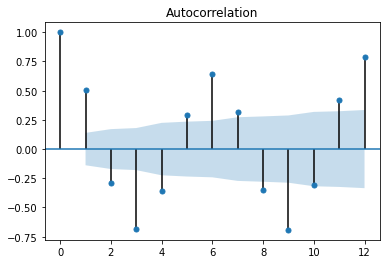

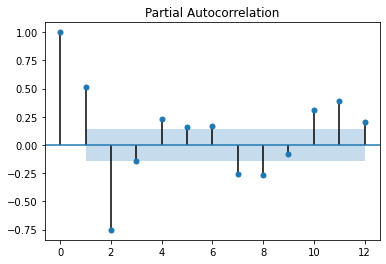

In [13]:
sm.graphics.tsa.plot_acf(data_m['PJME_MW'].values, lags=12)
plt.show()
sm.graphics.tsa.plot_pacf(data_m['PJME_MW'].values, lags=12)
plt.show()

In [14]:
# Определим p, d и q 
q = 1
p = 1
d = 1
pdq = [p, d, q]
# определим комбинации сезонных параметров p, q и q, 
#будем работать с недельными данными, тогда сезонность это 26 недель
qs = 0
ps = 0
ds = 1
seasonal_pdq = [ps, ds, qs ,12] 

In [15]:
mod = sm.tsa.statespace.SARIMAX(data_m['PJME_MW'].values[:-15],order=pdq,
                                seasonal_order=seasonal_pdq ,
                                enforce_stationarity= False ,
                                enforce_invertibility=False)
results = mod.fit()
print('SARIMAX{}x{} - AIC:{}'.format(pdq, seasonal_pdq, results.aic))

SARIMAX[1, 1, 1]x[0, 1, 0, 12] - AIC:3075.8349313063445


In [16]:
print(results.summary().tables[0],results.summary().tables[1])

                                 Statespace Model Results                                 
Dep. Variable:                                  y   No. Observations:                  185
Model:             SARIMAX(1, 1, 1)x(0, 1, 0, 12)   Log Likelihood               -1534.917
Date:                            Fri, 12 Jun 2020   AIC                           3075.835
Time:                                    14:52:35   BIC                           3085.242
Sample:                                         0   HQIC                          3079.652
                                            - 185                                         
Covariance Type:                              opg                                         
========================================================================================== ==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------

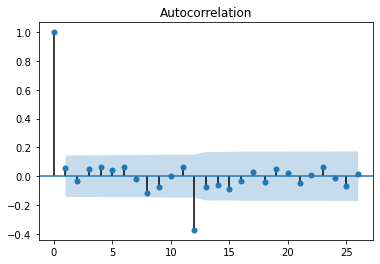

In [17]:
sm.graphics.tsa.plot_acf(results.resid, lags=26)
plt.show()

In [18]:
# results.plot_diagnostics(figsize=(15, 12))
# plt.show()

In [19]:
import itertools

# Определим p, d и q в диапазоне 0-3
p = d = q = range(0, 3)
# зададим сетку p, q и q
pdq = list(itertools.product(p, d, q))
# зададим сезонность p, q и q

p = [0] 
d = [0,1]
q = range(0, 3)
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[0]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[0]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[1]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 0, 0, 12)
SARIMAX: (0, 0, 2) x (0, 0, 0, 12)
SARIMAX: (0, 0, 2) x (0, 0, 1, 12)


In [20]:

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(data_m['PJME_MW'].values[:-15],order=param,
                                    seasonal_order=param_seasonal ,
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)

            results = mod.fit()
            print('ARIMA{}x{}3 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)3 - AIC:4345.074949633068
ARIMA(0, 0, 0)x(0, 0, 1, 12)3 - AIC:3946.7086428598395


C:\Users\Sladkish\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]


ARIMA(0, 0, 0)x(0, 0, 2, 12)3 - AIC:3646.0561759518514
ARIMA(0, 0, 0)x(0, 1, 0, 12)3 - AIC:3094.1438583735035
ARIMA(0, 0, 0)x(0, 1, 1, 12)3 - AIC:2870.287949871111
ARIMA(0, 0, 0)x(0, 1, 2, 12)3 - AIC:2642.365199621368
ARIMA(0, 0, 1)x(0, 0, 0, 12)3 - AIC:4191.002511217865
ARIMA(0, 0, 1)x(0, 0, 1, 12)3 - AIC:3885.1758293558287
ARIMA(0, 0, 1)x(0, 0, 2, 12)3 - AIC:3607.814537592918
ARIMA(0, 0, 1)x(0, 1, 0, 12)3 - AIC:3055.3485874321086
ARIMA(0, 0, 1)x(0, 1, 1, 12)3 - AIC:2833.3680343583633
ARIMA(0, 0, 1)x(0, 1, 2, 12)3 - AIC:2605.619287881791
ARIMA(0, 0, 2)x(0, 0, 0, 12)3 - AIC:4138.101302710473
ARIMA(0, 0, 2)x(0, 0, 1, 12)3 - AIC:3857.317773371667
ARIMA(0, 0, 2)x(0, 0, 2, 12)3 - AIC:3585.11073232574
ARIMA(0, 0, 2)x(0, 1, 0, 12)3 - AIC:3040.4758994564963
ARIMA(0, 0, 2)x(0, 1, 1, 12)3 - AIC:2818.508870372386
ARIMA(0, 0, 2)x(0, 1, 2, 12)3 - AIC:2585.146035915901
ARIMA(0, 1, 0)x(0, 0, 0, 12)3 - AIC:3505.7309362626056
ARIMA(0, 1, 0)x(0, 0, 1, 12)3 - AIC:3212.0253752964954
ARIMA(0, 1, 0)x(0, 0,

C:\Users\Sladkish\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 2)x(0, 0, 2, 12)3 - AIC:2924.948925523316
ARIMA(1, 0, 2)x(0, 1, 0, 12)3 - AIC:3041.6122302502217
ARIMA(1, 0, 2)x(0, 1, 1, 12)3 - AIC:2803.3110167295354
ARIMA(1, 0, 2)x(0, 1, 2, 12)3 - AIC:2582.134523240469
ARIMA(1, 1, 0)x(0, 0, 0, 12)3 - AIC:3487.484366079135
ARIMA(1, 1, 0)x(0, 0, 1, 12)3 - AIC:3202.7837472553383
ARIMA(1, 1, 0)x(0, 0, 2, 12)3 - AIC:2954.316726282319
ARIMA(1, 1, 0)x(0, 1, 0, 12)3 - AIC:3107.7790492655276
ARIMA(1, 1, 0)x(0, 1, 1, 12)3 - AIC:2849.0731971924856
ARIMA(1, 1, 0)x(0, 1, 2, 12)3 - AIC:2627.0778626024585
ARIMA(1, 1, 1)x(0, 0, 0, 12)3 - AIC:3453.2999966821135
ARIMA(1, 1, 1)x(0, 0, 1, 12)3 - AIC:3158.402216107656
ARIMA(1, 1, 1)x(0, 0, 2, 12)3 - AIC:2928.571919102741
ARIMA(1, 1, 1)x(0, 1, 0, 12)3 - AIC:3075.8349313063445
ARIMA(1, 1, 1)x(0, 1, 1, 12)3 - AIC:2792.6837815758327
ARIMA(1, 1, 1)x(0, 1, 2, 12)3 - AIC:2579.454600968995
ARIMA(1, 1, 2)x(0, 0, 0, 12)3 - AIC:3375.8941826048895
ARIMA(1, 1, 2)x(0, 0, 1, 12)3 - AIC:3085.7611001051373
ARIMA(1, 1, 2)x(0

C:\Users\Sladkish\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 0, 1)x(0, 1, 2, 12)3 - AIC:2604.5823867997733
ARIMA(2, 0, 2)x(0, 0, 0, 12)3 - AIC:3405.9681754708863
ARIMA(2, 0, 2)x(0, 0, 1, 12)3 - AIC:3127.3004600059367


C:\Users\Sladkish\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 0, 2)x(0, 0, 2, 12)3 - AIC:2901.3508620942375
ARIMA(2, 0, 2)x(0, 1, 0, 12)3 - AIC:3042.495198669784
ARIMA(2, 0, 2)x(0, 1, 1, 12)3 - AIC:2804.849297975615


C:\Users\Sladkish\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 0, 2)x(0, 1, 2, 12)3 - AIC:2583.1517895716047
ARIMA(2, 1, 0)x(0, 0, 0, 12)3 - AIC:3395.0231784792613
ARIMA(2, 1, 0)x(0, 0, 1, 12)3 - AIC:3169.4905859963455
ARIMA(2, 1, 0)x(0, 0, 2, 12)3 - AIC:2937.3539106490516
ARIMA(2, 1, 0)x(0, 1, 0, 12)3 - AIC:3066.3356997500787
ARIMA(2, 1, 0)x(0, 1, 1, 12)3 - AIC:2832.7044237199916
ARIMA(2, 1, 0)x(0, 1, 2, 12)3 - AIC:2612.7914801510988
ARIMA(2, 1, 1)x(0, 0, 0, 12)3 - AIC:3295.0654178424434
ARIMA(2, 1, 1)x(0, 0, 1, 12)3 - AIC:3071.377339980553
ARIMA(2, 1, 1)x(0, 0, 2, 12)3 - AIC:2857.8882208603186
ARIMA(2, 1, 1)x(0, 1, 0, 12)3 - AIC:3068.3206915253277
ARIMA(2, 1, 1)x(0, 1, 1, 12)3 - AIC:2806.2146624515444
ARIMA(2, 1, 1)x(0, 1, 2, 12)3 - AIC:2581.451460795185
ARIMA(2, 1, 2)x(0, 0, 0, 12)3 - AIC:3273.7339442481366
ARIMA(2, 1, 2)x(0, 0, 1, 12)3 - AIC:3024.095693849417
ARIMA(2, 1, 2)x(0, 0, 2, 12)3 - AIC:2815.168725256334
ARIMA(2, 1, 2)x(0, 1, 0, 12)3 - AIC:3050.284112244077


C:\Users\Sladkish\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 2)x(0, 1, 1, 12)3 - AIC:2785.032807835055


C:\Users\Sladkish\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 2)x(0, 1, 2, 12)3 - AIC:2564.255698263849
ARIMA(2, 2, 0)x(0, 0, 0, 12)3 - AIC:3509.4632630139704
ARIMA(2, 2, 0)x(0, 0, 1, 12)3 - AIC:3260.8551006985654
ARIMA(2, 2, 0)x(0, 0, 2, 12)3 - AIC:3021.2571539884225
ARIMA(2, 2, 0)x(0, 1, 0, 12)3 - AIC:3137.460007061912
ARIMA(2, 2, 0)x(0, 1, 1, 12)3 - AIC:2898.706145744293
ARIMA(2, 2, 0)x(0, 1, 2, 12)3 - AIC:2677.57016289267
ARIMA(2, 2, 1)x(0, 0, 0, 12)3 - AIC:3432.756072153995
ARIMA(2, 2, 1)x(0, 0, 1, 12)3 - AIC:3155.2105230521247
ARIMA(2, 2, 1)x(0, 0, 2, 12)3 - AIC:2926.5149930414273
ARIMA(2, 2, 1)x(0, 1, 0, 12)3 - AIC:3103.0049108742996
ARIMA(2, 2, 1)x(0, 1, 1, 12)3 - AIC:2842.1441645483937
ARIMA(2, 2, 1)x(0, 1, 2, 12)3 - AIC:2610.481658677437
ARIMA(2, 2, 2)x(0, 0, 0, 12)3 - AIC:3288.325990311448
ARIMA(2, 2, 2)x(0, 0, 1, 12)3 - AIC:3064.8279120972097
ARIMA(2, 2, 2)x(0, 0, 2, 12)3 - AIC:2851.164392976754
ARIMA(2, 2, 2)x(0, 1, 0, 12)3 - AIC:3081.286962752136
ARIMA(2, 2, 2)x(0, 1, 1, 12)3 - AIC:2795.317559910285
ARIMA(2, 2, 2)x(0, 1,

Выбираю минимальное значение Акаике : ARIMA(2, 1, 2)x(0, 1, 2, 12)3 - AIC:2564.255698263849

In [21]:
#для построения модели используем все данные, кроме 3-х последних месяцев (это будет тестовый набор)
N1=0
N2=15  # число точек для теста
nforecast = N2+30

mod = sm.tsa.statespace.SARIMAX(data_m['PJME_MW'].values[N1:-N2],order=[2,1,2],
                                seasonal_order=[0,1,2,12] ,
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results_opt = mod.fit()
print('AIC:{}',results_opt.aic)

C:\Users\Sladkish\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


AIC:{} 2564.255698263849


C:\Users\Sladkish\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:293: FutureWarning: RangeIndex._start is deprecated and will be removed in a future version. Use RangeIndex.start instead
  stop = base_index._start + (key + 1) * base_index._step
C:\Users\Sladkish\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:293: FutureWarning: RangeIndex._step is deprecated and will be removed in a future version. Use RangeIndex.step instead
  stop = base_index._start + (key + 1) * base_index._step
C:\Users\Sladkish\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:294: FutureWarning: RangeIndex._start is deprecated and will be removed in a future version. Use RangeIndex.start instead
  index = RangeIndex(start=base_index._start,
C:\Users\Sladkish\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:296: FutureWarning: RangeIndex._step is deprecated and will be removed in a future version. Use RangeIndex.step instead
  step=base_index._step)


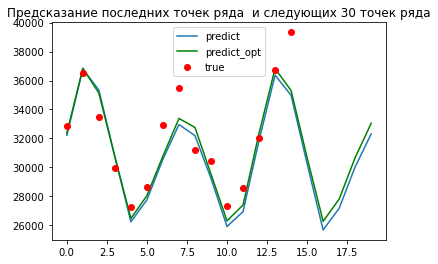

In [22]:
nforecast = N2+5  # полное число предиктов (тест+ чистый предикт)

pred_dynamic = results.forecast(nforecast)    #делаем предсказание на 30 точtк от текущего конца ряда
pred_dynamic_opt = results_opt.forecast(nforecast)

plt.plot(pred_dynamic, label='predict' )
plt.plot(pred_dynamic_opt,'g', label='predict_opt' )
#Отобразим истинный значения 
plt.plot(data_m['PJME_MW'].values[-N2:],'or',label='true')
plt.title('Предсказание последних точек ряда  и следующих 30 точек ряда')
plt.legend()

plt.show()

In [23]:
results_opt.summary().tables[1]

,coef,std err,z,P>|z|,[0.025,0.975]
ar.L1,-0.4057,0.755,-0.537,0.591,-1.886,1.075
ar.L2,0.2779,0.309,0.899,0.369,-0.328,0.884
ma.L1,-0.2590,0.784,-0.330,0.741,-1.796,1.278
ma.L2,-0.7886,0.800,-0.986,0.324,-2.356,0.779
ma.S.L12,-0.7938,0.094,-8.450,0.000,-0.978,-0.610
ma.S.L24,0.0733,0.082,0.893,0.372,-0.088,0.234
sigma2,2.237e+06,3e+05,7.447,0.000,1.65e+06,2.83e+06


C:\Users\Sladkish\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:293: FutureWarning: RangeIndex._start is deprecated and will be removed in a future version. Use RangeIndex.start instead
  stop = base_index._start + (key + 1) * base_index._step
C:\Users\Sladkish\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:293: FutureWarning: RangeIndex._step is deprecated and will be removed in a future version. Use RangeIndex.step instead
  stop = base_index._start + (key + 1) * base_index._step
C:\Users\Sladkish\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:294: FutureWarning: RangeIndex._start is deprecated and will be removed in a future version. Use RangeIndex.start instead
  index = RangeIndex(start=base_index._start,
C:\Users\Sladkish\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:296: FutureWarning: RangeIndex._step is deprecated and will be removed in a future version. Use RangeIndex.step instead
  step=base_index._step)


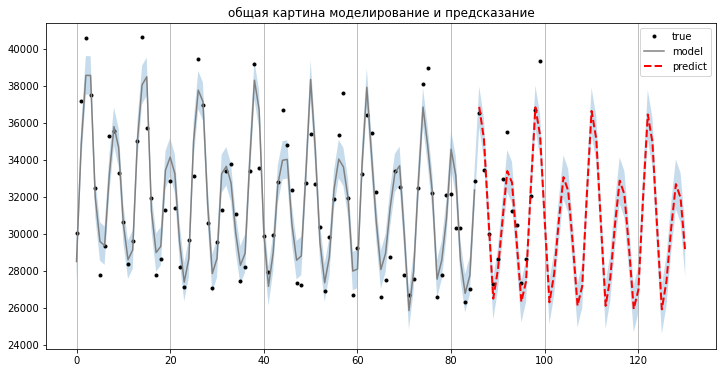

In [24]:
N3=100  # отступ данных для отображения  модели (для улучшения визуальных качеств рисунка - берем из интервала [0-500])
nforecast = N2+30  # общее число точек для предсказания (N2 - тестовых точек + точки для чистого предсказания)
predict_ = results_opt.get_prediction(end=results_opt.nobs + nforecast)  # делаем предсказание

# отображаем
idx = np.arange(len(predict_.predicted_mean)-N3)
predict_ci = predict_.conf_int(alpha=0.5)

#
fig, ax = plt.subplots(figsize=(12,6))
ax.xaxis.grid()
ax.plot(data_m['PJME_MW'].values[N3+N1:], 'k.',label='true')

# 
ax.plot(idx[:-nforecast], predict_.predicted_mean[N3:-nforecast], 'gray',label = 'model')
ax.plot(idx[-nforecast:], predict_.predicted_mean[-nforecast:], 'r--', linestyle='--', linewidth=2, label='predict')
ax.fill_between(idx, predict_ci[N3:, 0], predict_ci[N3:, 1], alpha=0.25)
plt.legend()
ax.set(title='общая картина моделирование и предсказание');

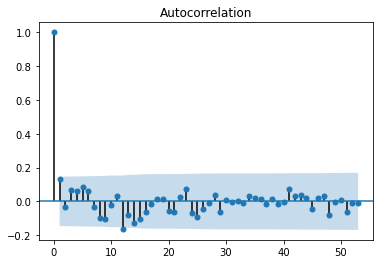

In [25]:
sm.graphics.tsa.plot_acf(results_opt.resid, lags=53)
plt.show()

Сделайте вывод о том, как изменилась модель по сравнению с недельной.

Вывод: На мой взгляд качетво предсказания увеличелось 

Возмите вариант 1 или 2

Вариант 1) - Постройте ACF, PACF и модель ARIMA для BRENT (недельный ресемплинг)


Вариант 2) - Постройте ACF, PACF и модель ARIMA для СOVID_19 (по любой стране кроме Китая на дневных графиках )
Оцените результат моделирования

Сделайте предположение о моделях, которые лучше работают с техниками регрессии на основе AR I MA.

In [26]:
path_brent = 'my_BRENT2019.csv'
brent_data = pd.read_csv(path_brent,sep = ',', index_col=[0], parse_dates=[0])
brent_data.head()

,Значение,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday
Дата,,,,,,,,,,,
2010-09-01,76.37,2010,9,1,3,244,35,2,0,0,0
2010-09-02,76.89,2010,9,2,3,245,35,3,0,0,0
2010-09-03,76.57,2010,9,3,3,246,35,4,0,0,0
2010-09-04,76.62,2010,9,4,3,247,35,5,0,0,0
2010-09-05,76.63,2010,9,5,3,248,35,6,0,1,0


Text(0.5, 0, 't')

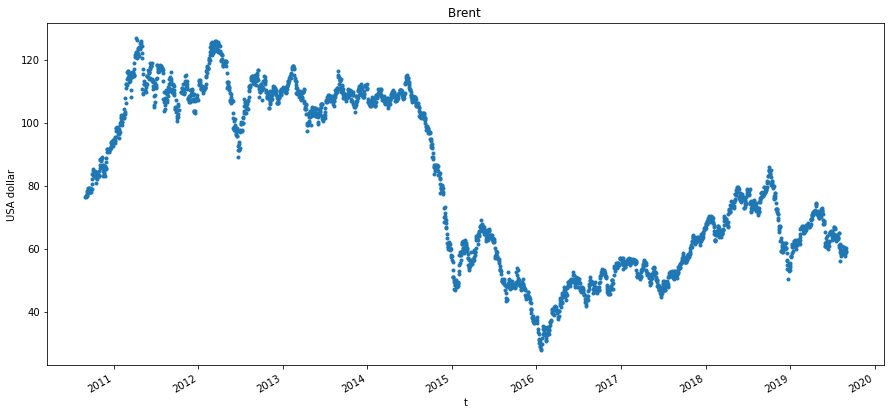

In [27]:
_ = brent_data['Значение'].plot( style='.', figsize=( 15, 7 ), title='Brent ')
plt.ylabel('USA dollar')
plt.xlabel('t')

In [28]:
brent_data_w = brent_data.resample('w').mean()

In [29]:
brent_data_w.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 470 entries, 2010-09-05 to 2019-09-01
Freq: W-SUN
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Значение         469 non-null    float64
 1   year             469 non-null    float64
 2   month            469 non-null    float64
 3   dayofmonth       469 non-null    float64
 4   quarter          469 non-null    float64
 5   dayofyear        469 non-null    float64
 6   weekofyear       469 non-null    float64
 7   dayofweek        469 non-null    float64
 8   is_holiday       469 non-null    float64
 9   is_prev_holiday  469 non-null    float64
 10  is_next_holiday  469 non-null    float64
dtypes: float64(11)
memory usage: 44.1 KB


Text(0.5, 0, 't')

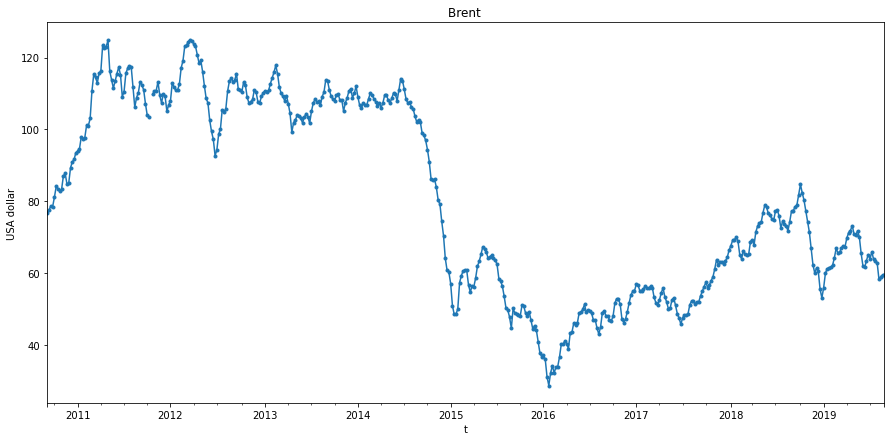

In [30]:
_ = brent_data_w['Значение'].plot( style='.-', figsize=( 15, 7 ), title='Brent ')
plt.ylabel('USA dollar')
plt.xlabel('t')

In [31]:
brent_data['2011-10-01':'2011-11-01']

,Значение,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday
Дата,,,,,,,,,,,
2011-10-02,101.40,2011,10,2,4,275,39,6,0,0,0
2011-10-03,100.69,2011,10,3,4,276,40,0,0,0,0
2011-10-04,101.96,2011,10,4,4,277,40,1,0,0,0
2011-10-05,102.77,2011,10,5,4,278,40,2,0,0,0
2011-10-06,105.40,2011,10,6,4,279,40,3,0,0,0
2011-10-07,105.91,2011,10,7,4,280,40,4,0,0,0
2011-10-09,104.13,2011,10,9,4,282,40,6,0,1,0
2011-10-20,109.93,2011,10,20,4,293,42,3,0,0,0
2011-10-21,109.79,2011,10,21,4,294,42,4,0,0,0


Как видим данные между 2011-10-09 и 2011-10-20 отсутсвуют

Text(0.5, 0, 't')

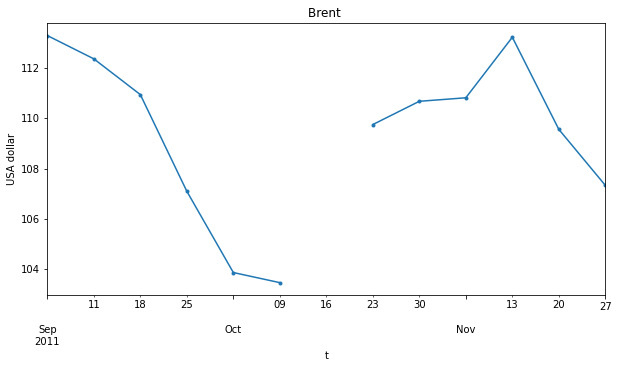

In [32]:
_ = brent_data_w['Значение']['2011-08-30 ':'2011-11-30 '].plot( style='.-', figsize=( 10, 5 ), title='Brent ')
plt.ylabel('USA dollar')
plt.xlabel('t')

In [33]:
brent_data_w['2011-09-25 ':'2011-10-30']

,Значение,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday
Дата,,,,,,,,,,,
2011-09-25,107.106667,2011.0,9.000000,21.666667,3.000000,264.666667,38.0,2.666667,0.0,0.000000,0.0
2011-10-02,103.878333,2011.0,9.166667,23.666667,3.166667,271.666667,39.0,2.666667,0.0,0.000000,0.0
2011-10-09,103.476667,2011.0,10.000000,5.666667,4.000000,278.666667,40.0,2.666667,0.0,0.166667,0.0
2011-10-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-10-23,109.756667,2011.0,10.000000,21.333333,4.000000,294.333333,42.0,4.333333,0.0,0.000000,0.0
2011-10-30,110.680000,2011.0,10.000000,26.666667,4.000000,299.666667,43.0,2.666667,0.0,0.000000,0.0


недельный перерасчет для даты 2011-10-16 записывает значение NaN

In [34]:
brent_data_w.loc['2011-10-09']

Значение            103.476667
year               2011.000000
month                10.000000
dayofmonth            5.666667
quarter               4.000000
dayofyear           278.666667
weekofyear           40.000000
dayofweek             2.666667
is_holiday            0.000000
is_prev_holiday       0.166667
is_next_holiday       0.000000
Name: 2011-10-09 00:00:00, dtype: float64

In [35]:
brent_data_w.loc['2011-10-16']

Значение          NaN
year              NaN
month             NaN
dayofmonth        NaN
quarter           NaN
dayofyear         NaN
weekofyear        NaN
dayofweek         NaN
is_holiday        NaN
is_prev_holiday   NaN
is_next_holiday   NaN
Name: 2011-10-16 00:00:00, dtype: float64

In [36]:
brent_data_w.loc['2011-10-23']

Значение            109.756667
year               2011.000000
month                10.000000
dayofmonth           21.333333
quarter               4.000000
dayofyear           294.333333
weekofyear           42.000000
dayofweek             4.333333
is_holiday            0.000000
is_prev_holiday       0.000000
is_next_holiday       0.000000
Name: 2011-10-23 00:00:00, dtype: float64

Заменяем пропуски средним значением соседних точек

In [37]:
brent_data_w.loc['2011-10-16']=(brent_data_w.loc['2011-10-09']+brent_data_w.loc['2011-10-23'])/2

In [38]:
brent_data_w.loc['2011-10-16']

Значение            106.616667
year               2011.000000
month                10.000000
dayofmonth           13.500000
quarter               4.000000
dayofyear           286.500000
weekofyear           41.000000
dayofweek             3.500000
is_holiday            0.000000
is_prev_holiday       0.083333
is_next_holiday       0.000000
Name: 2011-10-16 00:00:00, dtype: float64

Text(0.5, 0, 't')

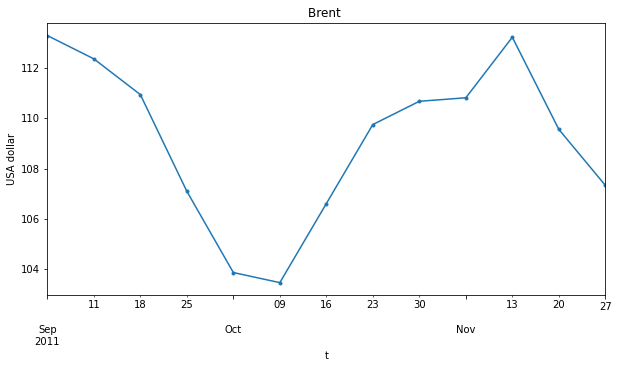

In [39]:
_ = brent_data_w['Значение']['2011-08-30 ':'2011-11-30 '].plot( style='.-', figsize=( 10, 5 ), title='Brent ')
plt.ylabel('USA dollar')
plt.xlabel('t')

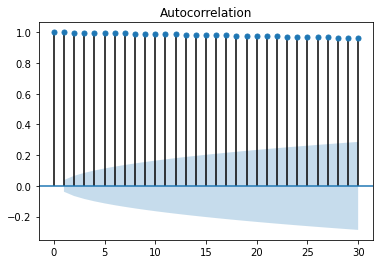

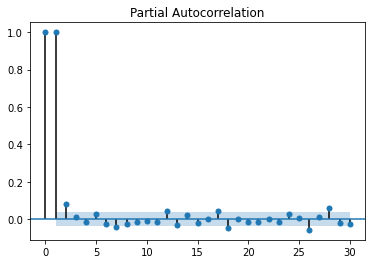

In [40]:
sm.graphics.tsa.plot_acf(brent_data['Значение'].values, lags=30)
plt.show()
#plt.subplot(2,1,2)
sm.graphics.tsa.plot_pacf(brent_data['Значение'].values, lags=30)
plt.show()

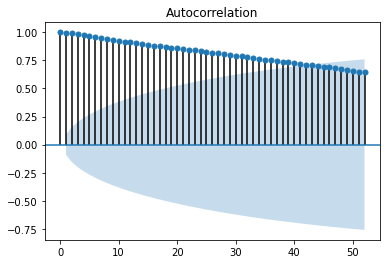

C:\Users\Sladkish\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


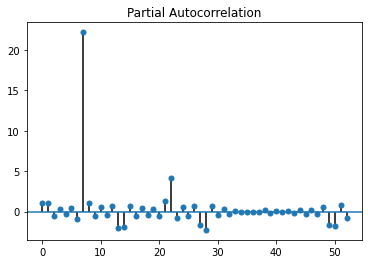

In [41]:
sm.graphics.tsa.plot_acf(brent_data_w['Значение'].values, lags=52)
plt.show()
#plt.subplot(2,1,2)
sm.graphics.tsa.plot_pacf(brent_data_w['Значение'].values, lags=52)
plt.show()

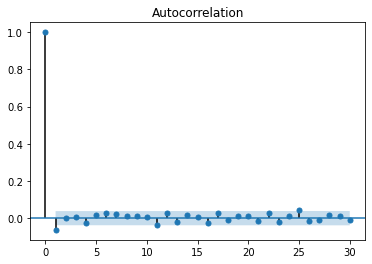

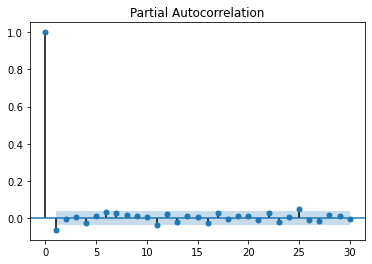

In [42]:
brent_dif = brent_data['Значение'].diff(1)

sm.graphics.tsa.plot_acf(brent_dif[1:], lags=30)
plt.show()
#plt.subplot(2,1,2)
sm.graphics.tsa.plot_pacf(brent_dif[1:], lags=30)
plt.show()

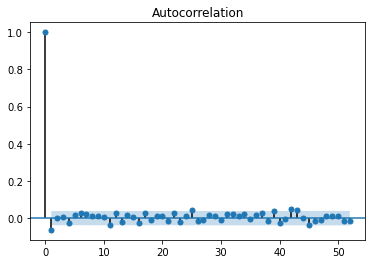

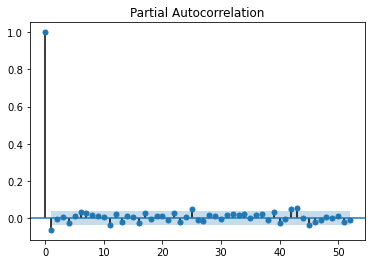

In [43]:
brent_dif_w = brent_data_w['Значение'].diff(1)

sm.graphics.tsa.plot_acf(brent_dif[1:], lags=52)
plt.show()
#plt.subplot(2,1,2)
sm.graphics.tsa.plot_pacf(brent_dif[1:], lags=52)
plt.show()

In [44]:
# Определим p, d и q 
q = 1
p = 2
d = 1
pdq = [p, d, q]

N2=30


modb = sm.tsa.statespace.SARIMAX(brent_data_w['Значение'].values[:-N2],
                               order=pdq,seasonal_order=[0,0,0,0], trend='ct',
                               enforce_stationarity=False,
                               enforce_invertibility=False)
resultsb = modb.fit()
print('ARIMA{} - AIC:{}'.format(pdq, resultsb.aic))

print(resultsb.summary().tables[0],resultsb.summary().tables[1])

ARIMA[2, 1, 1] - AIC:1910.5413305324475
                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                  440
Model:               SARIMAX(2, 1, 1)   Log Likelihood                -949.271
Date:                Fri, 12 Jun 2020   AIC                           1910.541
Time:                        14:54:02   BIC                           1935.021
Sample:                             0   HQIC                          1920.201
                                - 440                                         
Covariance Type:                  opg                                         
============================================================================== ==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   

In [46]:
# resultsb.plot_diagnostics(figsize=(15, 12))
# plt.show()

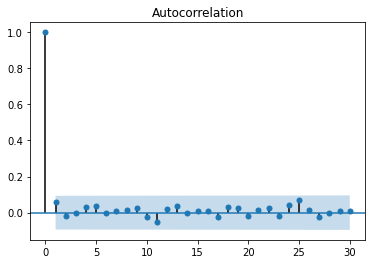

In [47]:
sm.graphics.tsa.plot_acf(resultsb.resid, lags=30)
plt.show()

C:\Users\Sladkish\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:293: FutureWarning: RangeIndex._start is deprecated and will be removed in a future version. Use RangeIndex.start instead
  stop = base_index._start + (key + 1) * base_index._step
C:\Users\Sladkish\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:293: FutureWarning: RangeIndex._step is deprecated and will be removed in a future version. Use RangeIndex.step instead
  stop = base_index._start + (key + 1) * base_index._step
C:\Users\Sladkish\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:294: FutureWarning: RangeIndex._start is deprecated and will be removed in a future version. Use RangeIndex.start instead
  index = RangeIndex(start=base_index._start,
C:\Users\Sladkish\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:296: FutureWarning: RangeIndex._step is deprecated and will be removed in a future version. Use RangeIndex.step instead
  step=base_index._step)


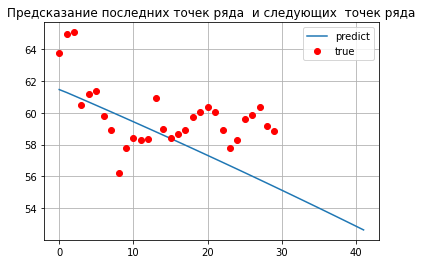

In [48]:
pred_dynamic = resultsb.forecast(42)    

plt.plot(pred_dynamic, label='predict' )
#Отобразим истинный значения 
plt.plot(brent_data['Значение'].values[-30:],'or',label='true')
plt.title('Предсказание последних точек ряда  и следующих  точек ряда')
plt.legend()
plt.grid()
plt.plot()
plt.show()

In [49]:
import itertools
import warnings
# Определим p, d и q в диапазоне 0-3
d = [0,1]
p = [0,1] 
q = range(0, 7)
# зададим сетку p, q и q
pdq = list(itertools.product(p, d, q))

seasonal_pdq = [0,0,0,0] # нет сезона

warnings.filterwarnings("ignore") # отключает предупреждения

for param in pdq:
    param_seasonal = seasonal_pdq
    try:
        mod_b = sm.tsa.statespace.SARIMAX(np.log(brent_data_w['Значение'].values[:-30]),
                                          order=param,seasonal_order=[0,0,0,0],trend='ct',
                                          enforce_stationarity=False,
                                          enforce_invertibility=False)

        results_ = mod_b.fit()
        print('ARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results_.aic))
    except:
        continue

ARIMA(0, 0, 0)x[0, 0, 0, 0] - AIC:68.44837354951066
ARIMA(0, 0, 1)x[0, 0, 0, 0] - AIC:-487.4245637315174
ARIMA(0, 0, 2)x[0, 0, 0, 0] - AIC:-890.4375195922111
ARIMA(0, 0, 3)x[0, 0, 0, 0] - AIC:-1143.4302735209226
ARIMA(0, 0, 4)x[0, 0, 0, 0] - AIC:-1299.1507530085723
ARIMA(0, 0, 5)x[0, 0, 0, 0] - AIC:-1363.5488525950782
ARIMA(0, 0, 6)x[0, 0, 0, 0] - AIC:-1264.2983978938687
ARIMA(0, 1, 0)x[0, 0, 0, 0] - AIC:-1747.338831745748
ARIMA(0, 1, 1)x[0, 0, 0, 0] - AIC:-1797.827785764747
ARIMA(0, 1, 2)x[0, 0, 0, 0] - AIC:-1790.974853095589
ARIMA(0, 1, 3)x[0, 0, 0, 0] - AIC:-1785.8750113401059
ARIMA(0, 1, 4)x[0, 0, 0, 0] - AIC:-1778.9864826310907
ARIMA(0, 1, 5)x[0, 0, 0, 0] - AIC:-1774.1280344964835
ARIMA(0, 1, 6)x[0, 0, 0, 0] - AIC:-1770.7217554340436
ARIMA(1, 0, 0)x[0, 0, 0, 0] - AIC:-1753.203185982541
ARIMA(1, 0, 1)x[0, 0, 0, 0] - AIC:-1804.2098141294982
ARIMA(1, 0, 2)x[0, 0, 0, 0] - AIC:-1797.374611762022
ARIMA(1, 0, 3)x[0, 0, 0, 0] - AIC:-1791.4540102474575
ARIMA(1, 0, 4)x[0, 0, 0, 0] - AIC:-17

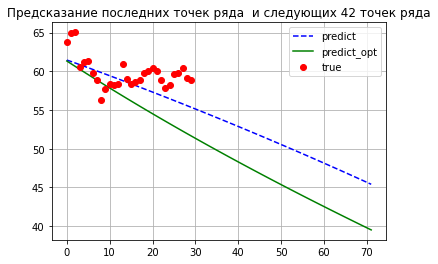

In [50]:
N2=30
nforecast = N2+42

modb_opt = sm.tsa.statespace.SARIMAX(brent_data_w['Значение'].values[:-N2],
                               order=[1,0,1],seasonal_order=[0,0,0,0],trend='ct',
                               enforce_stationarity=False,
                               enforce_invertibility=False)
resultsb_opt = modb_opt.fit()
pred_dynamic = resultsb.forecast(nforecast)    #делаем предсказание c 30 точки от текущего конца ряда
pred_dynamic_opt = resultsb_opt.forecast(72) 

plt.plot(pred_dynamic,'--b', label='predict' )
plt.plot(pred_dynamic_opt,'g', label='predict_opt' )
#Отобразим истинный значения 
plt.plot(brent_data['Значение'].values[-N2:],'or',label='true')
plt.title('Предсказание последних точек ряда  и следующих 42 точек ряда')
plt.legend()
plt.grid()
plt.show()

In [51]:
resultsb_opt.summary().tables[1]

,coef,std err,z,P>|z|,[0.025,0.975]
intercept,1.5144,0.961,1.576,0.115,-0.369,3.398
drift,-0.0025,0.002,-1.475,0.140,-0.006,0.001
ar.L1,0.9877,0.008,124.729,0.000,0.972,1.003
ma.L1,0.3697,0.045,8.274,0.000,0.282,0.457
sigma2,4.4877,0.258,17.388,0.000,3.982,4.994


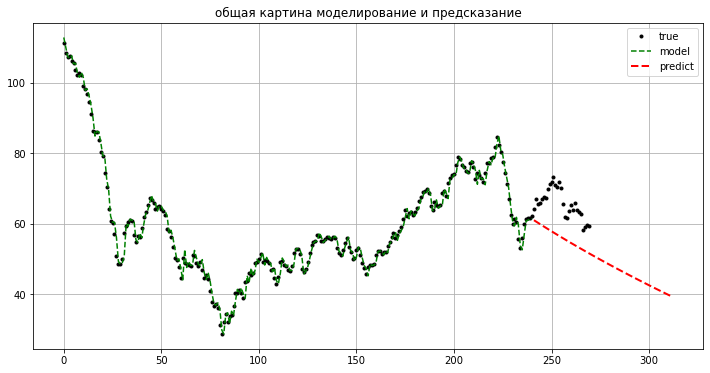

In [52]:
N2=30 # число точек для теста
nforecast = N2+42  # общее число точек для предсказания (тест+ чистое предсказание)
N3=200  # отступ от начала известной информации для визуализации - так виднее (можно брать 0-2600)
predict_ = resultsb_opt.get_prediction(end=resultsb_opt.nobs + nforecast)   
# получаем результаты работы модели по всей выборке

# отображаем результаты
idx = np.arange(len(predict_.predicted_mean)-N3)
predict_ci = predict_.conf_int(alpha=0.5)

#
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(brent_data_w['Значение'].values[N3:], 'k.',label='true')

plt.grid()
ax.plot(idx[:-nforecast], predict_.predicted_mean[N3:-nforecast], '--g',label='model')
ax.plot(idx[-nforecast:], predict_.predicted_mean[-nforecast:], 'r--', linestyle='--', linewidth=2,label = 'predict')
# ax.fill_between(idx, predict_ci[N3:, 0], predict_ci[N3:, 1], alpha=0.15)
plt.legend()

ax.set(title='общая картина моделирование и предсказание');

In [53]:

adf_test = sm.tsa.stattools.adfuller(resultsb_opt.resid)
print(adf_test)

(-41.53119870331168, 0.0, 0, 439, {'1%': -3.4453339386510784, '5%': -2.868146269723016, '10%': -2.5702889034926137}, 1834.4894294479172)
